figure out math behind how to see if collections are being watched in order more so than not

In [2]:
import pandas as pd
import pymysql

# Establishes a connection to your MySQL database
connection = pymysql.connect(
    host='127.0.0.1',
    user='readonly',
    password='',  # Enter your database password here
    database='ML3_mirror'
)

# SQL query to fetch ratings from multiple collections, ordered by rating timestamp
sql_query = """
SELECT user_rating_pairs.userId, user_rating_pairs.movieId, user_rating_pairs.rating, user_rating_pairs.tstamp, movie_tmdb_data.title, movie_tmdb_data.releaseDate, movie_tmdb_data.collection
FROM user_rating_pairs
JOIN movie_tmdb_data ON user_rating_pairs.movieId = movie_tmdb_data.movieId
WHERE movie_tmdb_data.collection IN ('Star Wars Collection') AND user_rating_pairs.userId IN (402850)
ORDER BY user_rating_pairs.userId, user_rating_pairs.tstamp;
"""

# Executes the SQL query and store the results in a DataFrame
ratings_df = pd.read_sql(sql_query, connection)

# Ensures releaseDate is datetime type
ratings_df['releaseDate'] = pd.to_datetime(ratings_df['releaseDate'])

# Determines if each user rated the movies in chronological order of their release
ratings_df['correct_order'] = ratings_df.groupby(['userId', 'collection'])['releaseDate'].diff().fillna(pd.Timedelta(seconds=0)) >= pd.Timedelta(seconds=0)
result = ratings_df.groupby(['userId', 'collection'])['correct_order'].all()

# Prints or further analyze the results
print(result)

# Saves the DataFrame to a CSV file
ratings_df.to_csv('collections_data.csv', index=False)

# Closes the database connection
connection.close()

userId  collection          
402850  Star Wars Collection    False
Name: correct_order, dtype: bool


/var/folders/fw/fl0fmc554_g4ghgsxkcn0n7m0000gn/T/ipykernel_31721/3555727983.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratings_df = pd.read_sql(sql_query, connection)


In [3]:
data = pd.read_csv("collections_data.csv")
data.head(50)

,userId,movieId,rating,tstamp,title,releaseDate,collection,correct_order
0,402850,122886,4.0,2023-10-31 12:50:05,Star Wars: The Force Awakens,2015-12-15,Star Wars Collection,True
1,402850,1196,4.0,2024-02-01 11:16:09,The Empire Strikes Back,1980-05-20,Star Wars Collection,False
2,402850,208205,3.0,2024-04-17 11:02:29,Star Wars: The Rise of Skywalker,2019-12-18,Star Wars Collection,True
3,402850,179819,3.0,2024-04-17 11:02:31,Star Wars: The Last Jedi,2017-12-13,Star Wars Collection,False
4,402850,2628,3.0,2024-04-17 11:03:02,Star Wars: Episode I - The Phantom Menace,1999-05-19,Star Wars Collection,False
5,402850,33493,3.0,2024-04-17 11:03:04,Star Wars: Episode III - Revenge of the Sith,2005-05-17,Star Wars Collection,True
6,402850,5378,2.5,2024-04-17 11:03:05,Star Wars: Episode II - Attack of the Clones,2002-05-15,Star Wars Collection,False


In [ ]:
import pandas as pd
import pymysql
import numpy as np

# Establish connection to MySQL database
connection = pymysql.connect(
    host='127.0.0.1',
    user='readonly',
    password='',  # Enter your database password here
    database='ML3_mirror'
)

# Define chunk size for processing
CHUNK_SIZE = 50000  # Adjust based on memory constraints
chunk_count = 0  # Track number of processed chunks

# SQL query (without ORDER BY for efficiency)
sql_query = """
SELECT user_rating_pairs.userId, user_rating_pairs.movieId, user_rating_pairs.tstamp, 
       movie_tmdb_data.releaseDate, movie_tmdb_data.collection
FROM user_rating_pairs
JOIN movie_tmdb_data ON user_rating_pairs.movieId = movie_tmdb_data.movieId
WHERE movie_tmdb_data.collection IS NOT NULL 
    AND movie_tmdb_data.releaseDate != '0000-00-00';
"""

# Dictionary to store order correctness per user-collection pair
user_collection_results = {}

print("Starting to process chunks...")

# Process in chunks
for chunk in pd.read_sql_query(sql_query, connection, chunksize=CHUNK_SIZE):
    chunk_count += 1
    print(f"Processing chunk {chunk_count}...")

    # Convert releaseDate to datetime
    chunk['releaseDate'] = pd.to_datetime(chunk['releaseDate'], errors='coerce')

    # Check chronological order within each chunk
    for (user, collection), group in chunk.groupby(['userId', 'collection']):
        rel_dates = group['releaseDate'].values  # Convert to NumPy array
        order_correct = np.all(np.diff(rel_dates) >= np.timedelta64(0, 's'))  # Check order

        # Store result, keeping track of previous values
        if (user, collection) in user_collection_results:
            user_collection_results[(user, collection)] &= order_correct
        else:
            user_collection_results[(user, collection)] = order_correct

    print(f"Chunk {chunk_count} processed. Total unique (user, collection) pairs so far: {len(user_collection_results)}")

print("All chunks processed. Aggregating results...")

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(user_collection_results, orient='index', columns=['correct_order'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['userId', 'collection'])

# Compute percentage of users who rated in order per collection
collection_order_percentage = results_df.groupby('collection')['correct_order'].mean() * 100  # Convert to percentage

print("Final aggregation complete!")

# Print results
print("Percentage of users who rated in order for each collection:")
print(collection_order_percentage)

# Save results to CSV
collection_order_percentage.to_csv('collection_order_percentage.csv', header=['percentage'])
print("Results saved to collection_order_percentage.csv")

# Close database connection
connection.close()
print("Database connection closed.")

Starting to process chunks...


/var/folders/fw/fl0fmc554_g4ghgsxkcn0n7m0000gn/T/ipykernel_62264/2512482116.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  for chunk in pd.read_sql_query(sql_query, connection, chunksize=CHUNK_SIZE):


Processing chunk 1...
Chunk 1 processed. Total unique (user, collection) pairs so far: 46632
Processing chunk 2...
Chunk 2 processed. Total unique (user, collection) pairs so far: 93663
Processing chunk 3...
Chunk 3 processed. Total unique (user, collection) pairs so far: 141036
Processing chunk 4...
Chunk 4 processed. Total unique (user, collection) pairs so far: 188385
Processing chunk 5...
Chunk 5 processed. Total unique (user, collection) pairs so far: 235733
Processing chunk 6...
Chunk 6 processed. Total unique (user, collection) pairs so far: 283192
Processing chunk 7...
Chunk 7 processed. Total unique (user, collection) pairs so far: 330732
Processing chunk 8...
Chunk 8 processed. Total unique (user, collection) pairs so far: 377919
Processing chunk 9...
Chunk 9 processed. Total unique (user, collection) pairs so far: 424851
Processing chunk 10...
Chunk 10 processed. Total unique (user, collection) pairs so far: 472246
Processing chunk 11...
Chunk 11 processed. Total unique (use

# ratings that are super close together cannot be reliable, if two ratings are close together assume they are in order 

In [6]:
import pandas as pd
import pymysql
import numpy as np

# Establish connection to MySQL database
connection = pymysql.connect(
    host='127.0.0.1',
    user='readonly',
    password='',  # Enter your database password here
    database='ML3_mirror'
)

# Define chunk size for processing
CHUNK_SIZE = 50000  # Adjust based on memory constraints
chunk_count = 0  # Track number of processed chunks

# Define time threshold (e.g., 1 hour in seconds)
TIME_THRESHOLD = 3600  # 1 hour tolerance for close timestamps

# SQL query (without ORDER BY for efficiency)
sql_query = """
SELECT user_rating_pairs.userId, user_rating_pairs.movieId, user_rating_pairs.tstamp, 
       movie_tmdb_data.releaseDate, movie_tmdb_data.collection
FROM user_rating_pairs
JOIN movie_tmdb_data ON user_rating_pairs.movieId = movie_tmdb_data.movieId
WHERE movie_tmdb_data.collection IS NOT NULL 
    AND movie_tmdb_data.releaseDate != '0000-00-00';
"""

# Dictionary to store order correctness per user-collection pair
user_collection_results = {}

print("Starting to process chunks...")

# Process in chunks
for chunk in pd.read_sql_query(sql_query, connection, chunksize=CHUNK_SIZE):
    chunk_count += 1
    print(f"Processing chunk {chunk_count}...")

    # Convert releaseDate to datetime
    chunk['releaseDate'] = pd.to_datetime(chunk['releaseDate'], errors='coerce')

    # Convert timestamp to datetime
    chunk['tstamp'] = pd.to_datetime(chunk['tstamp'], unit='s')  # Convert UNIX timestamp

    # Check chronological order within each chunk
    for (user, collection), group in chunk.groupby(['userId', 'collection']):
        # Sort by timestamp
        group = group.sort_values('tstamp')

        # Get release dates and timestamps as NumPy arrays
        rel_dates = group['releaseDate'].values
        timestamps = group['tstamp'].values.astype('datetime64[s]')  # Convert to seconds precision

        # Compute time differences
        time_diffs = np.diff(timestamps).astype('timedelta64[s]').astype(int)

        # Allow small variations (if diff is negative but within TIME_THRESHOLD, consider in order)
        order_correct = np.all((np.diff(rel_dates) >= np.timedelta64(0, 's')) | (time_diffs < TIME_THRESHOLD))

        # Store result, keeping track of previous values
        if (user, collection) in user_collection_results:
            user_collection_results[(user, collection)] &= order_correct
        else:
            user_collection_results[(user, collection)] = order_correct

    print(f"Chunk {chunk_count} processed. Total unique (user, collection) pairs so far: {len(user_collection_results)}")

print("All chunks processed. Aggregating results...")

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(user_collection_results, orient='index', columns=['correct_order'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['userId', 'collection'])

# Compute percentage of users who rated in order per collection
collection_order_percentage = results_df.groupby('collection')['correct_order'].mean() * 100  # Convert to percentage

print("Final aggregation complete!")

# Print results
print("Percentage of users who rated in order for each collection:")
print(collection_order_percentage)

# Save results to CSV
collection_order_percentage.to_csv('collection_order_percentage.csv', header=['percentage'])
print("Results saved to collection_order_percentage.csv")

# Close database connection
connection.close()
print("Database connection closed.")

Starting to process chunks...


/var/folders/fw/fl0fmc554_g4ghgsxkcn0n7m0000gn/T/ipykernel_26832/20412271.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  for chunk in pd.read_sql_query(sql_query, connection, chunksize=CHUNK_SIZE):


Processing chunk 1...
Chunk 1 processed. Total unique (user, collection) pairs so far: 50000
Processing chunk 2...
Chunk 2 processed. Total unique (user, collection) pairs so far: 100000
Processing chunk 3...
Chunk 3 processed. Total unique (user, collection) pairs so far: 150000
Processing chunk 4...
Chunk 4 processed. Total unique (user, collection) pairs so far: 200000
Processing chunk 5...
Chunk 5 processed. Total unique (user, collection) pairs so far: 250000
Processing chunk 6...
Chunk 6 processed. Total unique (user, collection) pairs so far: 300000
Processing chunk 7...
Chunk 7 processed. Total unique (user, collection) pairs so far: 350000
Processing chunk 8...
Chunk 8 processed. Total unique (user, collection) pairs so far: 400000
Processing chunk 9...
Chunk 9 processed. Total unique (user, collection) pairs so far: 450000
Processing chunk 10...
Chunk 10 processed. Total unique (user, collection) pairs so far: 500000
Processing chunk 11...
Chunk 11 processed. Total unique (us

In [ ]:
import pandas as pd
import pymysql
import numpy as np

# Establish connection to MySQL database
connection = pymysql.connect(
    host='127.0.0.1',
    user='readonly',
    password='',  # Enter your database password here
    database='ML3_mirror'
)

# Defines chunk size for processing
CHUNK_SIZE = 50000  # Adjust based on memory constraints
chunk_count = 0  # Track number of processed chunks

# Defines time threshold (e.g., 1 hour in seconds)
TIME_THRESHOLD = 3600  # 1 hour tolerance for close timestamps

#Defines a max age difference for filtering (e.g., 20 years)
MAX_MOVIE_AGE_YEARS = 20
current_year = pd.Timestamp.now().year

# SQL query (without ORDER BY for efficiency)
sql_query = """
SELECT user_rating_pairs.userId, user_rating_pairs.movieId, user_rating_pairs.tstamp, 
       movie_tmdb_data.releaseDate, movie_tmdb_data.collection
FROM user_rating_pairs
JOIN movie_tmdb_data ON user_rating_pairs.movieId = movie_tmdb_data.movieId
WHERE movie_tmdb_data.collection IS NOT NULL 
    AND movie_tmdb_data.releaseDate != '0000-00-00';
"""

# Dictionary to store order correctness per user-collection pair
user_collection_results = {}

print("Starting to process chunks...")

# Process in chunks
for chunk in pd.read_sql_query(sql_query, connection, chunksize=CHUNK_SIZE):
    chunk_count += 1
    print(f"Processing chunk {chunk_count}...")

    # Convert releaseDate and timestamp to datetime
    chunk['releaseDate'] = pd.to_datetime(chunk['releaseDate'], errors='coerce') #replaces uncovertable times with NaT
    chunk['tstamp'] = pd.to_datetime(chunk['tstamp'], unit='s')  # Convert UNIX timestamp

    # Optional: Filter out movies released too long before the rating
    chunk = chunk[chunk['releaseDate'].dt.year >= (current_year - MAX_MOVIE_AGE_YEARS)]

    # Group by (user, collection)
    for (user, collection), group in chunk.groupby(['userId', 'collection']):
        # Sort by timestamp
        group = group.sort_values('tstamp')

        # Get release dates and timestamps as NumPy arrays
        rel_dates = group['releaseDate'].values
        timestamps = group['tstamp'].values.astype('datetime64[s]')  # Convert to seconds precision

        # Compute time differences
        time_diffs = np.diff(timestamps).astype('timedelta64[s]').astype(int)

        # Remove "same hour" pairs (exclude pairs where diff < TIME_THRESHOLD)
        valid_indices = np.where(time_diffs >= TIME_THRESHOLD)[0]
        rel_dates_filtered = rel_dates[:-1][valid_indices]
        rel_dates_next = rel_dates[1:][valid_indices]

        # Check chronological order on filtered pairs
        order_correct = np.all(rel_dates_next >= rel_dates_filtered)

        # Store result, keeping track of previous values
        if (user, collection) in user_collection_results:
            user_collection_results[(user, collection)] &= order_correct
        else:
            user_collection_results[(user, collection)] = order_correct

    print(f"Chunk {chunk_count} processed. Total unique (user, collection) pairs so far: {len(user_collection_results)}")

print("All chunks processed. Aggregating results...")

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(user_collection_results, orient='index', columns=['correct_order'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['userId', 'collection'])

# Compute percentage of users who rated in order per collection
collection_order_percentage = results_df.groupby('collection')['correct_order'].mean() * 100  # Convert to percentage

print("Final aggregation complete!")

# Print results
print("Percentage of users who rated in order for each collection:")
print(collection_order_percentage)

# Save results to CSV
collection_order_percentage.to_csv('collection_order_percentage.csv', header=['percentage'])
print("Results saved to collection_order_percentage.csv")

# Close database connection
connection.close()
print("Database connection closed.")

Starting to process chunks...


/var/folders/fw/fl0fmc554_g4ghgsxkcn0n7m0000gn/T/ipykernel_31559/2216609143.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  for chunk in pd.read_sql_query(sql_query, connection, chunksize=CHUNK_SIZE):


Processing chunk 1...
Chunk 1 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 2...
Chunk 2 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 3...
Chunk 3 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 4...
Chunk 4 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 5...
Chunk 5 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 6...
Chunk 6 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 7...
Chunk 7 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 8...
Chunk 8 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 9...
Chunk 9 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 10...
Chunk 10 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 11...
Chunk 11 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 

# Updated Code As of 4/10

In [2]:
import pandas as pd
import pymysql
import numpy as np

# Establish connection to MySQL database
connection = pymysql.connect(
    host='127.0.0.1',
    user='readonly',
    password='',  # Enter your database password here
    database='ML3_mirror'
)

# Configuration
CHUNK_SIZE = 50000
TIME_THRESHOLD = 3600  # 1 hour in seconds
MAX_MOVIE_AGE_YEARS = 20
current_year = pd.Timestamp.now().year

# Query for chronological order analysis
sql_query = """
SELECT user_rating_pairs.userId, user_rating_pairs.movieId, user_rating_pairs.tstamp, 
       movie_tmdb_data.releaseDate, movie_tmdb_data.collection
FROM user_rating_pairs
JOIN movie_tmdb_data ON user_rating_pairs.movieId = movie_tmdb_data.movieId
WHERE movie_tmdb_data.collection IS NOT NULL 
    AND movie_tmdb_data.releaseDate != '0000-00-00';
"""

# Dictionary to store order correctness
user_collection_results = {}

print("Starting to process chunks for chronological order...")

# Process in chunks
chunk_count = 0
for chunk in pd.read_sql_query(sql_query, connection, chunksize=CHUNK_SIZE):
    chunk_count += 1
    print(f"Processing chunk {chunk_count}...")

    chunk['releaseDate'] = pd.to_datetime(chunk['releaseDate'], errors='coerce')
    chunk['tstamp'] = pd.to_datetime(chunk['tstamp'], unit='s')

    chunk = chunk[chunk['releaseDate'].dt.year >= (current_year - MAX_MOVIE_AGE_YEARS)]

    for (user, collection), group in chunk.groupby(['userId', 'collection']):
        group = group.sort_values('tstamp')
        rel_dates = group['releaseDate'].values
        timestamps = group['tstamp'].values.astype('datetime64[s]')
        time_diffs = np.diff(timestamps).astype('timedelta64[s]').astype(int)

        valid_indices = np.where(time_diffs >= TIME_THRESHOLD)[0]
        rel_dates_filtered = rel_dates[:-1][valid_indices]
        rel_dates_next = rel_dates[1:][valid_indices]

        order_correct = np.all(rel_dates_next >= rel_dates_filtered)

        if (user, collection) in user_collection_results:
            user_collection_results[(user, collection)] &= order_correct
        else:
            user_collection_results[(user, collection)] = order_correct

    print(f"Chunk {chunk_count} processed. Total unique (user, collection) pairs so far: {len(user_collection_results)}")

print("All chunks processed. Aggregating results...")

# Create DataFrame of order results
results_df = pd.DataFrame.from_dict(user_collection_results, orient='index', columns=['correct_order'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['userId', 'collection'])

collection_order_percentage = results_df.groupby('collection')['correct_order'].mean() * 100
collection_order_percentage.to_csv('collection_order_percentage.csv', header=['percentage'])

print("Chronological order percentages saved to 'collection_order_percentage.csv'")

# ============== NEW PART: Collection vs Non-Collection Analysis ==============

print("Starting user-level collection vs non-collection rating analysis...")

query_all_ratings = """
SELECT urp.userId, urp.movieId, mtd.collection
FROM user_rating_pairs urp
LEFT JOIN movie_tmdb_data mtd ON urp.movieId = mtd.movieId;
"""

all_ratings = pd.read_sql_query(query_all_ratings, connection)

# Determine whether each rating is for a movie in a collection
all_ratings['in_collection'] = all_ratings['collection'].notnull()

# Compute per-user rating stats
user_rating_stats = all_ratings.groupby('userId')['in_collection'].agg(
    total_ratings='count',
    collection_ratings='sum'
)
user_rating_stats['non_collection_ratings'] = user_rating_stats['total_ratings'] - user_rating_stats['collection_ratings']
user_rating_stats['percent_collection'] = (user_rating_stats['collection_ratings'] / user_rating_stats['total_ratings']) * 100
user_rating_stats['percent_non_collection'] = 100 - user_rating_stats['percent_collection']

# Only keep users who rated at least one collection movie
filtered_users = user_rating_stats[user_rating_stats['collection_ratings'] > 0]

# Save to CSV
filtered_users[['percent_collection', 'percent_non_collection']].to_csv('user_collection_rating_percentages.csv')

print("User-level collection vs non-collection percentages saved to 'user_collection_rating_percentages.csv'")

# Close connection
connection.close()
print("Database connection closed.")

Starting to process chunks for chronological order...


/var/folders/fw/fl0fmc554_g4ghgsxkcn0n7m0000gn/T/ipykernel_14662/2750047606.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  for chunk in pd.read_sql_query(sql_query, connection, chunksize=CHUNK_SIZE):


Processing chunk 1...
Chunk 1 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 2...
Chunk 2 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 3...
Chunk 3 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 4...
Chunk 4 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 5...
Chunk 5 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 6...
Chunk 6 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 7...
Chunk 7 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 8...
Chunk 8 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 9...
Chunk 9 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 10...
Chunk 10 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 11...
Chunk 11 processed. Total unique (user, collection) pairs so far: 0
Processing chunk 

/var/folders/fw/fl0fmc554_g4ghgsxkcn0n7m0000gn/T/ipykernel_14662/2750047606.py:85: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_ratings = pd.read_sql_query(query_all_ratings, connection)


User-level collection vs non-collection percentages saved to 'user_collection_rating_percentages.csv'
Database connection closed.


Collections by Watched Percentage Range:
               Number of Collections
watched_range                       
0–25%                              2
26–50%                             7
51–75%                            29
76–99%                           282
100%                            2442


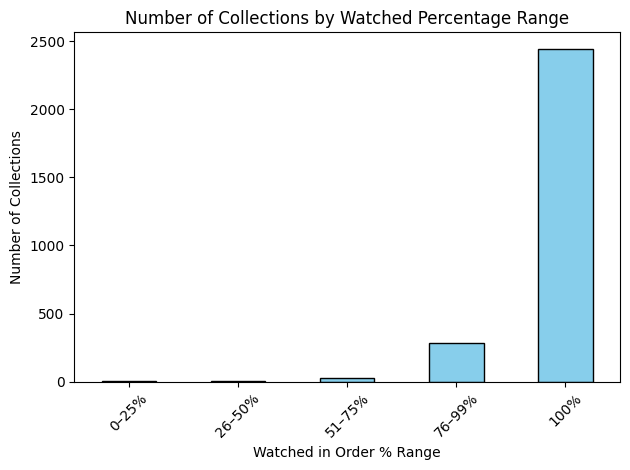

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv('collection_order_percentage.csv')

# Clean column names if needed
df.columns = df.columns.str.strip()

# Define the bins and labels
bins = [0, 25, 50, 75, 99, 100]
labels = ['0–25%', '26–50%', '51–75%', '76–99%', '100%']

# Bin the percentage column
df['watched_range'] = pd.cut(df['percentage'], bins=bins, labels=labels, include_lowest=True, right=True)

# Count number of collections in each range
range_counts = df['watched_range'].value_counts().sort_index()

# Display as table
print("Collections by Watched Percentage Range:")
print(range_counts.to_frame(name='Number of Collections'))

# Plot bar chart
range_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Collections by Watched Percentage Range')
plt.xlabel('Watched in Order % Range')
plt.ylabel('Number of Collections')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

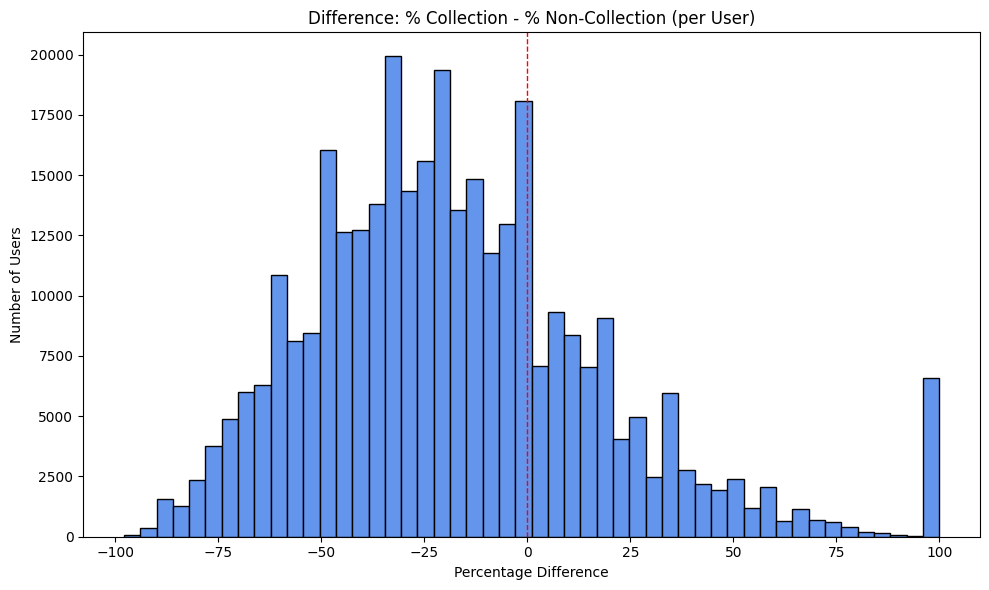

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the big dataset
df = pd.read_csv('user_collection_rating_percentages.csv')

# Calculate the difference
df['diff'] = df['percent_collection'] - df['percent_non_collection']

# Plot histogram of differences
plt.figure(figsize=(10, 6))
plt.hist(df['diff'], bins=50, color='cornflowerblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Difference: % Collection - % Non-Collection (per User)')
plt.xlabel('Percentage Difference')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import pymysql
import numpy as np

# Establish connection to MySQL database
connection = pymysql.connect(
    host='127.0.0.1',
    user='readonly',
    password='',  # Enter your database password here
    database='ML3_mirror'
)

# Configuration
CHUNK_SIZE = 50000

# Query for chronological order analysis
sql_query = """
SELECT user_rating_pairs.userId, user_rating_pairs.movieId, user_rating_pairs.tstamp, 
       movie_tmdb_data.releaseDate, movie_tmdb_data.collection
FROM user_rating_pairs
JOIN movie_tmdb_data ON user_rating_pairs.movieId = movie_tmdb_data.movieId
WHERE movie_tmdb_data.collection IS NOT NULL 
    AND movie_tmdb_data.releaseDate != '0000-00-00';
"""

# Dictionary to store order correctness
user_collection_results = {}

print("Starting to process chunks for chronological order...")

# Process in chunks
chunk_count = 0
for chunk in pd.read_sql_query(sql_query, connection, chunksize=CHUNK_SIZE):
    chunk_count += 1
    print(f"Processing chunk {chunk_count}...")

    chunk['releaseDate'] = pd.to_datetime(chunk['releaseDate'], errors='coerce')
    chunk['tstamp'] = pd.to_datetime(chunk['tstamp'], unit='s')

    for (user, collection), group in chunk.groupby(['userId', 'collection']):
        group = group.sort_values('tstamp')
        rel_dates = group['releaseDate'].values
        rel_dates_next = rel_dates[1:]
        rel_dates_filtered = rel_dates[:-1]

        order_correct = np.all(rel_dates_next >= rel_dates_filtered)

        if (user, collection) in user_collection_results:
            user_collection_results[(user, collection)] &= order_correct
        else:
            user_collection_results[(user, collection)] = order_correct

    print(f"Chunk {chunk_count} processed. Total unique (user, collection) pairs so far: {len(user_collection_results)}")

print("All chunks processed. Aggregating results...")

# Create DataFrame of order results
results_df = pd.DataFrame.from_dict(user_collection_results, orient='index', columns=['correct_order'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['userId', 'collection'])

collection_order_percentage = results_df.groupby('collection')['correct_order'].mean() * 100
collection_order_percentage.to_csv('collection_order_percentage_without_time_threshold.csv', header=['percentage'])

print("Chronological order percentages saved to 'collection_order_percentage_without_time_threshold.csv'")

# ============== NEW PART: Collection vs Non-Collection Analysis ==============

print("Starting user-level collection vs non-collection rating analysis...")

query_all_ratings = """
SELECT urp.userId, urp.movieId, mtd.collection
FROM user_rating_pairs urp
LEFT JOIN movie_tmdb_data mtd ON urp.movieId = mtd.movieId;
"""

all_ratings = pd.read_sql_query(query_all_ratings, connection)

# Determine whether each rating is for a movie in a collection
all_ratings['in_collection'] = all_ratings['collection'].notnull()

# Compute per-user rating stats
user_rating_stats = all_ratings.groupby('userId')['in_collection'].agg(
    total_ratings='count',
    collection_ratings='sum'
)
user_rating_stats['non_collection_ratings'] = user_rating_stats['total_ratings'] - user_rating_stats['collection_ratings']
user_rating_stats['percent_collection'] = (user_rating_stats['collection_ratings'] / user_rating_stats['total_ratings']) * 100
user_rating_stats['percent_non_collection'] = 100 - user_rating_stats['percent_collection']

# Only keep users who rated at least one collection movie
filtered_users = user_rating_stats[user_rating_stats['collection_ratings'] > 0]

# Save to CSV
filtered_users[['percent_collection', 'percent_non_collection']].to_csv('user_collection_rating_percentages_without_time_threshold.csv')

print("User-level collection vs non-collection percentages saved to 'user_collection_rating_percentages_wihout_time_threshold.csv'")

# Close connection
connection.close()
print("Database connection closed.")

Starting to process chunks for chronological order...


/var/folders/fw/fl0fmc554_g4ghgsxkcn0n7m0000gn/T/ipykernel_86880/2361246074.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  for chunk in pd.read_sql_query(sql_query, connection, chunksize=CHUNK_SIZE):


Processing chunk 1...
Chunk 1 processed. Total unique (user, collection) pairs so far: 50000
Processing chunk 2...
Chunk 2 processed. Total unique (user, collection) pairs so far: 100000
Processing chunk 3...
Chunk 3 processed. Total unique (user, collection) pairs so far: 150000
Processing chunk 4...
Chunk 4 processed. Total unique (user, collection) pairs so far: 200000
Processing chunk 5...
Chunk 5 processed. Total unique (user, collection) pairs so far: 250000
Processing chunk 6...
Chunk 6 processed. Total unique (user, collection) pairs so far: 300000
Processing chunk 7...
Chunk 7 processed. Total unique (user, collection) pairs so far: 350000
Processing chunk 8...
Chunk 8 processed. Total unique (user, collection) pairs so far: 400000
Processing chunk 9...
Chunk 9 processed. Total unique (user, collection) pairs so far: 450000
Processing chunk 10...
Chunk 10 processed. Total unique (user, collection) pairs so far: 500000
Processing chunk 11...
Chunk 11 processed. Total unique (us

/var/folders/fw/fl0fmc554_g4ghgsxkcn0n7m0000gn/T/ipykernel_86880/2361246074.py:76: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_ratings = pd.read_sql_query(query_all_ratings, connection)


User-level collection vs non-collection percentages saved to 'user_collection_rating_percentages_wihout_time_threshold.csv'
Database connection closed.


Collections by Watched Percentage Range:
               Number of Collections
watched_range                       
0–25%                             28
26–50%                            94
51–75%                           227
76–99%                           702
100%                            3416


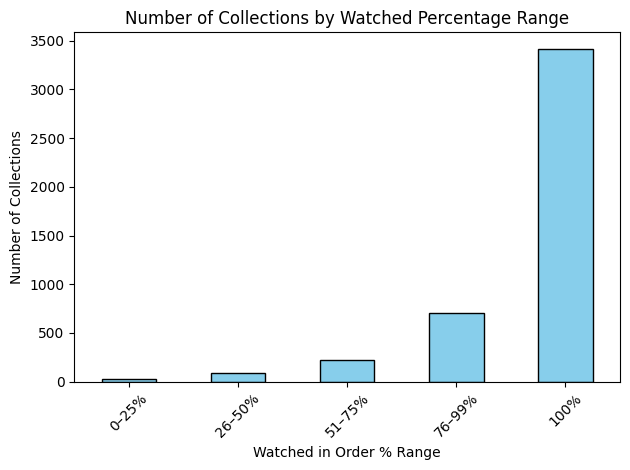

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv('collection_order_percentage_without_time_threshold.csv')

# Clean column names if needed
df.columns = df.columns.str.strip()

# Define the bins and labels
bins = [0, 25, 50, 75, 99, 100]
labels = ['0–25%', '26–50%', '51–75%', '76–99%', '100%']

# Bin the percentage column
df['watched_range'] = pd.cut(df['percentage'], bins=bins, labels=labels, include_lowest=True, right=True)

# Count number of collections in each range
range_counts = df['watched_range'].value_counts().sort_index()

# Display as table
print("Collections by Watched Percentage Range:")
print(range_counts.to_frame(name='Number of Collections'))

# Plot bar chart
range_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Collections by Watched Percentage Range')
plt.xlabel('Watched in Order % Range')
plt.ylabel('Number of Collections')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

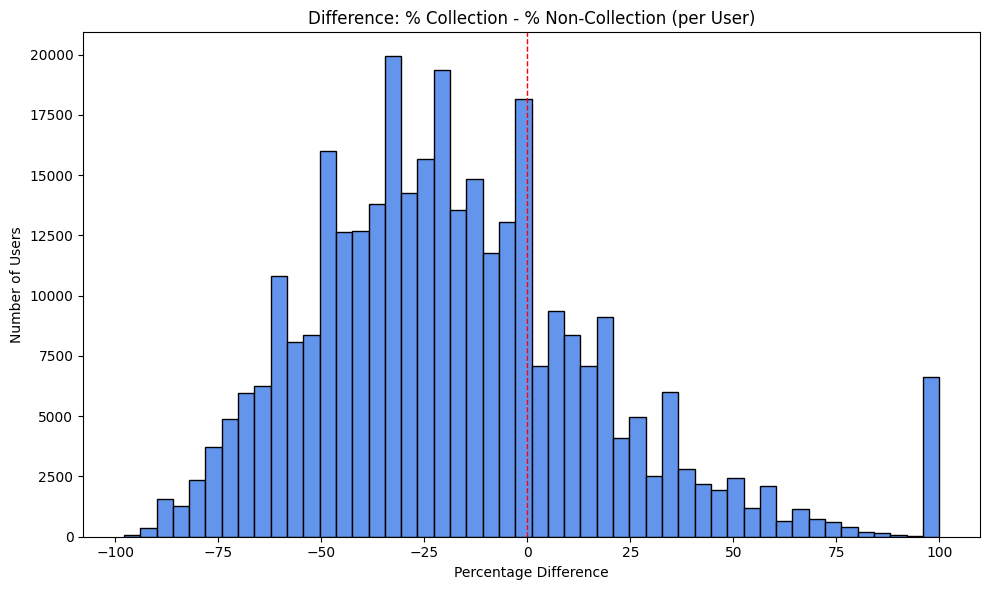

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the big dataset
df = pd.read_csv('user_collection_rating_percentages_without_time_threshold.csv')

# Calculate the difference
df['diff'] = df['percent_collection'] - df['percent_non_collection']

# Plot histogram of differences
plt.figure(figsize=(10, 6))
plt.hist(df['diff'], bins=50, color='cornflowerblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Difference: % Collection - % Non-Collection (per User)')
plt.xlabel('Percentage Difference')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Shown above is the distribution without the removal of "insufficient" pairs